In [28]:
import warnings
import sys
warnings.filterwarnings('ignore')
sys.path.append('../')

import pandas as pd 
import seaborn as sns 
import numpy as np
import copy
from sklearn.manifold import TSNE

from rdkit import Chem

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import descriptors.preprocessing as pp
import descriptors.dft_featurisation as ft


# Set matplotlib style 
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'axes.titlesize' : 25,
    'axes.labelsize' : 19,
    'legend.fontsize' : 18,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

matplotlib.rcParams['axes.unicode_minus'] = False
sns.set_style("white")
%matplotlib inline 

In [29]:
# Load NiCOlit dataset
df = pd.read_csv("data/NiCOlit.csv", sep = ',')

df2 = pp.preprocess(df)

In [30]:
df.columns

Index(['substrate', 'coupling_partner', 'effective_coupling_partner',
       'solvent', 'time', 'temperature', 'catalyst_precursor', 'reagents',
       'effective_reagents', 'effective_reagents_covalent', 'reductant',
       'ligand', 'effective_ligand', 'product', 'analytical_yield',
       'isolated_yield', 'coupling_partner_class', 'DOI', 'origin',
       'eq_substrate', 'eq_coupling_partner', 'eq_catalyst', 'eq_ligand',
       'eq_reagent', '2_steps', 'scheme_table', 'review', 'Mechanism'],
      dtype='object')

In [31]:
# DFT Featurize NiCOlit dataset
X, y, DOIs, coupling_partners, origins = ft.process_dataframe_dft(copy.copy(df2), data_path="data/utils/")
display_df =  pd.DataFrame(zip(y, coupling_partners, origins, DOIs), 
                           columns =['Yields', 'Coupling Partners', 'Origin', 'DOIs'])

# Rename Coupling Partner Classes
dois = np.unique(DOIs)

In [32]:
# Perform TSNE of the NiCOlit featurized and get two frist components
X_embedded = TSNE(n_components=2, random_state=11).fit_transform(X)
tsne1 = [i[0] for i in X_embedded]
tsne2 = [i[1] for i in X_embedded]

In [33]:
# Choose a DOI, Coupling Partner, Substrate
num_doi = 10     # DOI choice
num_coupl = 1  # Boronic Partner
num_sub = 5     # Substrate 

coupling_partner = np.unique(coupling_partners)
substrates = df2["substrate"].unique()

# Perform data splitting random, by DOI, by coupling partner and by substrate
nums = np.random.choice([0, 1], size=len(X_embedded), p=[.3, .7])
nums[0] = 1
random_split = ["Test Set" if i == 0 else "Train Set" for i in nums]
doi_split = ["Test Set" if i == dois[num_doi] else "Train Set" for i in DOIs]
coupl_split = ["Test Set" if i == coupling_partner[num_coupl] else "Train Set" for i in coupling_partners]
substrate_split = ["Test Set" if i == 'CC(C)(C)C(=O)Oc1ccc2ccccc2c1' else "Train Set" for i in df2["substrate"]]

# Make data_frame for future plot
tsne_df = pd.DataFrame(zip(tsne1, tsne2, DOIs, coupling_partners, origins, y, 
                           random_split, doi_split, coupl_split, substrate_split), 
                       columns =['TSNE 1', 'TSNE 2', 'DOIs', 'Coupling Partners', 'Origin', 
                                 'Yields', 'Random Split', 'DOI Split', 
                                 'Coupling Reagent Split', 'Subtrate Split'])


## Visualize DOI and Coupling Partner TSNE Distributions

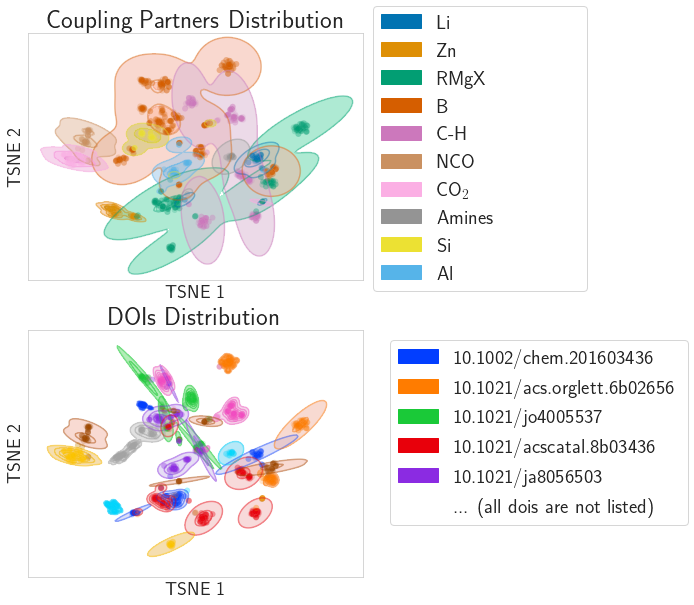

In [34]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_palette(sns.color_palette("colorblind"))
fig, ax = plt.subplots(2, 1, figsize=(6, 10))

# first plot TSNE by Coupling Partner
sns.kdeplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="Coupling Partners", fill=False, thresh=0.03,
                gridsize=100,
                cut = 5, alpha  = 0.4, linewidth=50,
            levels=4,
           ax = ax[0])

sns.kdeplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="Coupling Partners", fill=True, thresh=0.03,
                gridsize=100, alpha  = 0.5,
             levels=4,
           ax = ax[0])

legend = ax[0].get_legend()
labels = [] if legend is None else [str(x._text) for x in legend.texts]
handles = [] if legend is None else legend.legendHandles
ax[0].get_legend().remove()

sns.scatterplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="Coupling Partners", legend=False,
                alpha=0.2, linewidth=0.1, ax= ax[0])

nice_labels = ['Organolithium', 'Organozinc', 'Organomagnesium', 'Organoboron', 
               'Activated C-H', 'Isocyanates', 'Carbon Dioxide', 'Amines', 
               'Aryl Silanes', 'Organoaluminum']

short_labels = ['Li', 'Zn', 'RMgX', 'B', 
               'C-H', 'NCO', 'CO$_2$', 'Amines', 
               'Si', 'Al']

ax[0].set_title("Coupling Partners Distribution")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xbound(lower=-75, upper=85)
ax[0].set_ybound(lower=-75, upper=70)
ax[0].legend(handles, short_labels, 
             bbox_to_anchor=(1.00, 0.15, 0.7, 1), 
             ncol=1,
             mode= "expand",
            fontsize=20)


# plot TSNE by DOIs
sns.set_palette(sns.color_palette("rocket"))
sns.kdeplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="DOIs", fill=False, thresh=0.05,
                palette='bright',
                gridsize=100, alpha  = 0.4, linewidth=50, ax = ax[1])

sns.kdeplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="DOIs", fill=True, thresh=0.05,
                palette='bright',
                gridsize=100, alpha  = 0.5, ax = ax[1])

legend = ax[1].get_legend()
labels = [] if legend is None else [str(x._text) for x in legend.texts]
handles = [] if legend is None else legend.legendHandles
ax[1].get_legend().remove()

sns.scatterplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="DOIs", legend=False,
                palette='bright',
                alpha=0.2, 
                linewidth=0.1,
                ax= ax[1])

ax[1].set_title("DOIs Distribution")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xbound(lower=-75, upper=85)
ax[1].set_ybound(lower=-75, upper=70)

# make legend
h = handles[:5]
h_fin = patches.Rectangle(h[0].get_xy(), h[0].get_width(), h[0].get_height())
h_fin.set_color('white')
h.append(h_fin)
l = labels[:5]
l_reduced = [label.replace('https://doi.org/', '') for label in l]
l_reduced.append("... (all dois are not listed)")
ax[1].legend(h, l_reduced, bbox_to_anchor=(1.05, 0, 0.95, 1), mode="expand", ncol=1,
            fontsize=20)

plt.savefig("images/exploration1.svg", dpi=300, bbox_inches='tight')
plt.show()

## Visualize Data Splitting depending on the Prediction Task Performed

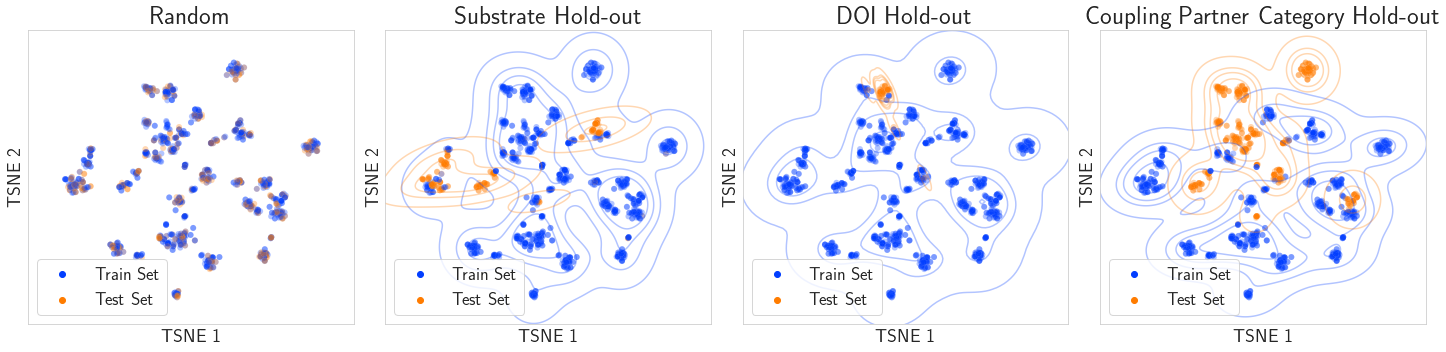

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Random split task
sns.scatterplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="Random Split", legend=True,
                alpha=0.3, palette='bright', linewidth=0.1, ax = ax[0])

ax[0].set_title("Random")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xbound(lower=-75, upper=75)
ax[0].set_ybound(lower=-70, upper=70)
#ax[0].legend(bbox_to_anchor=(0, -0.2, 1, 1), ncol=2, mode="expand")
ax[0].legend(title=None)


# Substrate split task
sns.kdeplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
            hue="Subtrate Split", 
            fill=False, thresh=0.05,
            palette ='bright', gridsize=300, alpha = 0.3,
            levels=5, ax = ax[1])

sns.scatterplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="Subtrate Split", legend=True,
                alpha=0.3, palette='bright', linewidth=0.1, ax = ax[1])

ax[1].set_title("Substrate Hold-out")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xbound(lower=-75, upper=75)
ax[1].set_ybound(lower=-70, upper=70)
ax[1].legend(title=None)

# DOI split task
sns.kdeplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
            hue="DOI Split", 
            fill=False, thresh=0.01,
            levels=5,
            palette ='bright', gridsize=100, alpha = 0.3,
            ax = ax[2])

sns.scatterplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="DOI Split", legend=True,
                alpha=0.3, 
                palette='bright', linewidth=0.1,
                ax = ax[2])

ax[2].set_title("DOI Hold-out")
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xbound(lower=-75, upper=75)
ax[2].set_ybound(lower=-70, upper=70)
#ax[1].legend(bbox_to_anchor=(0, -0.2, 1, 1), ncol=2, mode="expand")
ax[2].legend(title=None)


# Coupling Reagent Class - Split Task
sns.kdeplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
            hue="Coupling Reagent Split", 
            fill=False, thresh=0.05,
            palette ='bright', gridsize=300, alpha = 0.3,
            levels=5, ax = ax[3])

sns.scatterplot(data=tsne_df, x="TSNE 1", y="TSNE 2", 
                hue="Coupling Reagent Split", legend=True,
                alpha=0.3, palette='bright', linewidth=0.1, ax = ax[3])

ax[3].set_title("Coupling Partner Category Hold-out")
ax[3].set_xticks([])
ax[3].set_yticks([])
ax[3].set_xbound(lower=-75, upper=75)
ax[3].set_ybound(lower=-70, upper=70)
ax[3].legend(title=None)

#fig.suptitle('Train/Test Splits of the NiCOLit dataset', size=35)
fig.tight_layout()
plt.savefig("images/exploration2.svg", dpi=300, bbox_inches='tight')
plt.show()

## Visualize Data Splitting on a Restricted Chemical Space

In [26]:
# Restricted to one type of Coupling Partner :
Boron_df = tsne_df[tsne_df["Coupling Reagent Split"] == "Test Set"]
Not_Boron_df = tsne_df[tsne_df["Coupling Reagent Split"] == "Train Set"]

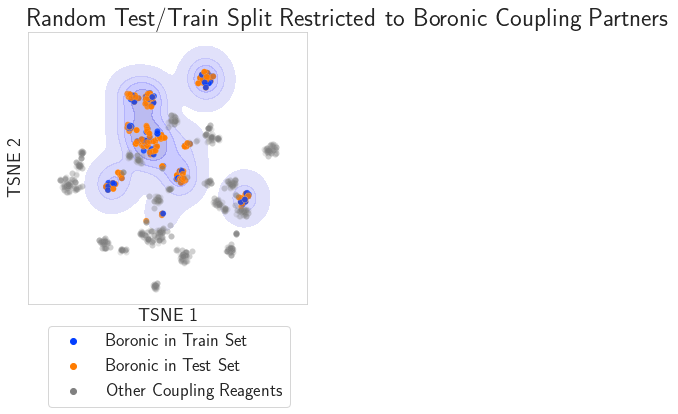

In [27]:
ax = plt.figure(figsize=(5, 5))
# plot Boron data point and density
sns.kdeplot(data=Boron_df, x="TSNE 1", y="TSNE 2",
            fill=True, thresh=0.05,
            color='blue', gridsize=100,
            alpha = 0.4, linewidth=50,
           levels =5)

ax = sns.scatterplot(data=Boron_df, x="TSNE 1", y="TSNE 2", 
                hue="Random Split",
                alpha=0.8, 
                palette='bright', linewidth=0.1)

legend = ax.get_legend()
labels = [] if legend is None else [str(x._text) for x in legend.texts]
handles = legend.legendHandles

# plot not used data points
ax2 = sns.scatterplot(data=Not_Boron_df, x="TSNE 1", y="TSNE 2", 
                legend=True, alpha=0.2, 
                color='gray', linewidth=0.1)

# make common legend
legend2 = ax2.get_legend()
h3 = legend2.legendHandles[0]
h3.set_color("gray")
ax2.get_legend().remove()
h = [handles[0], handles[1], h3]
l = ["Boronic in Train Set", "Boronic in Test Set", "Other Coupling Reagents"]

# set figure titles and legend
ax.set_title("Random Test/Train Split Restricted to Boronic Coupling Partners", loc='left')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xbound(lower=-75, upper=75)
ax.set_ybound(lower=-65, upper=75)
ax.legend(h, l, bbox_to_anchor=(0.97, -0.05), 
             ncol=1, title=None, fontsize=18)

plt.savefig("images/exploration_restricted.svg", dpi=600, bbox_inches='tight')
plt.show()